# Deepracer Optimal Race Line and Action Space
Source 1:

https://github.com/dgnzlz/Capstone_AWS_DeepRacer/blob/master/Compute_Speed_And_Actions/Race-Line-Calculation.ipynb

Source 2: https://github.com/dgnzlz/Capstone_AWS_DeepRacer/blob/master/Compute_Speed_And_Actions/RaceLine_Speed_ActionSpace.ipynb



In [ ]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from sklearn.cluster import KMeans
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [ ]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['arctic_open_ccw']

Is loop/ring?  True


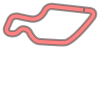

In [ ]:
# Replace the name here with the track to analyze
TRACK_NAME = 'arctic_open_ccw'

# Load the center, inner, outer waypoints
waypoints = np.load("%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
inner_border_coords = np.array(l_inner_border.xy).T
outer_border_coords = np.array(l_outer_border.xy).T

# Flip the coordinates vertically
flipped_inner_coords = np.flipud(inner_border_coords)
flipped_outer_coords = np.flipud(outer_border_coords)

# Create the road polygon
road_poly = Polygon(np.vstack((flipped_outer_coords, flipped_inner_coords)))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

Is loop/ring?  True


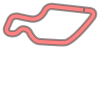

In [ ]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def x_perc_width(waypoint, perc_width):

    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint

    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)

    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y

    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)

    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.8
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)
# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
inner_border_coords_new = np.array(l_inner_border_new.xy).T
outer_border_coords_new = np.array(l_outer_border_new.xy).T


# Flip the coordinates vertically
flipped_inner_coords_new = np.flipud(inner_border_coords_new)
flipped_outer_coords_new = np.flipud(outer_border_coords_new)
# Create the road polygon
road_poly_new = Polygon(np.vstack((flipped_outer_coords_new, flipped_inner_coords_new)))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

# Display the original track waypoints

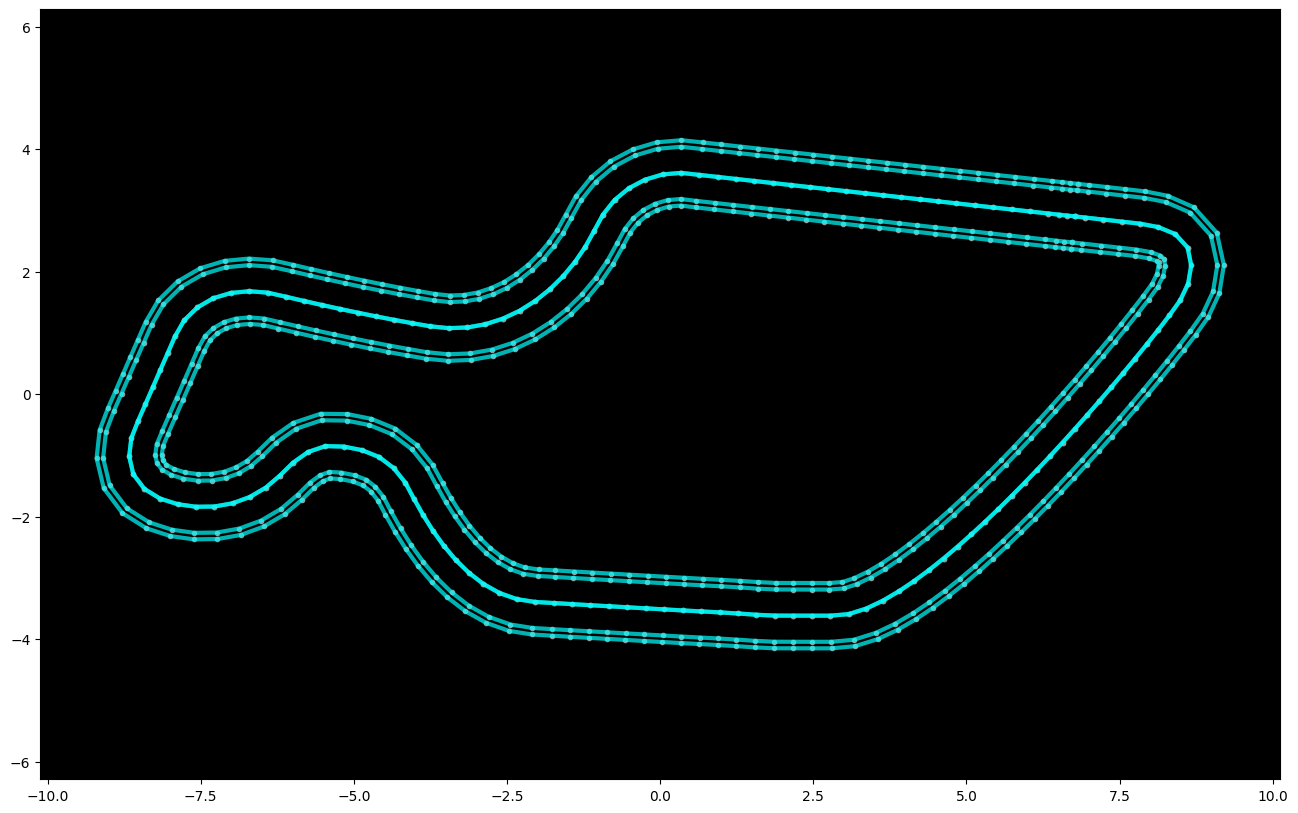

In [ ]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, '.', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
print_border(ax, center_line, inner_border_new, outer_border_new)

In [ ]:
# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=10000

In [ ]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [ ]:
def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [ ]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

143
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980
Iteration 1000
Iteration 1020
Iteration 1040
Iteration 1060
Iteration 1080
Iteration 1100
Iteration 1120
Iteration 1140
Iteration 1160
Iteration 1180
Iteration 1200
Iteration 1220
Iteration 1240
Iteration 1260
Iteration 1280
Iteration 1300
Iteration 1320
Iteration 1340
Iteration 1360
Iteration 1380
It

These should be the same:  ((143, 2), (143, 2))
Original centerline length: 42.19
New race line length: 37.84


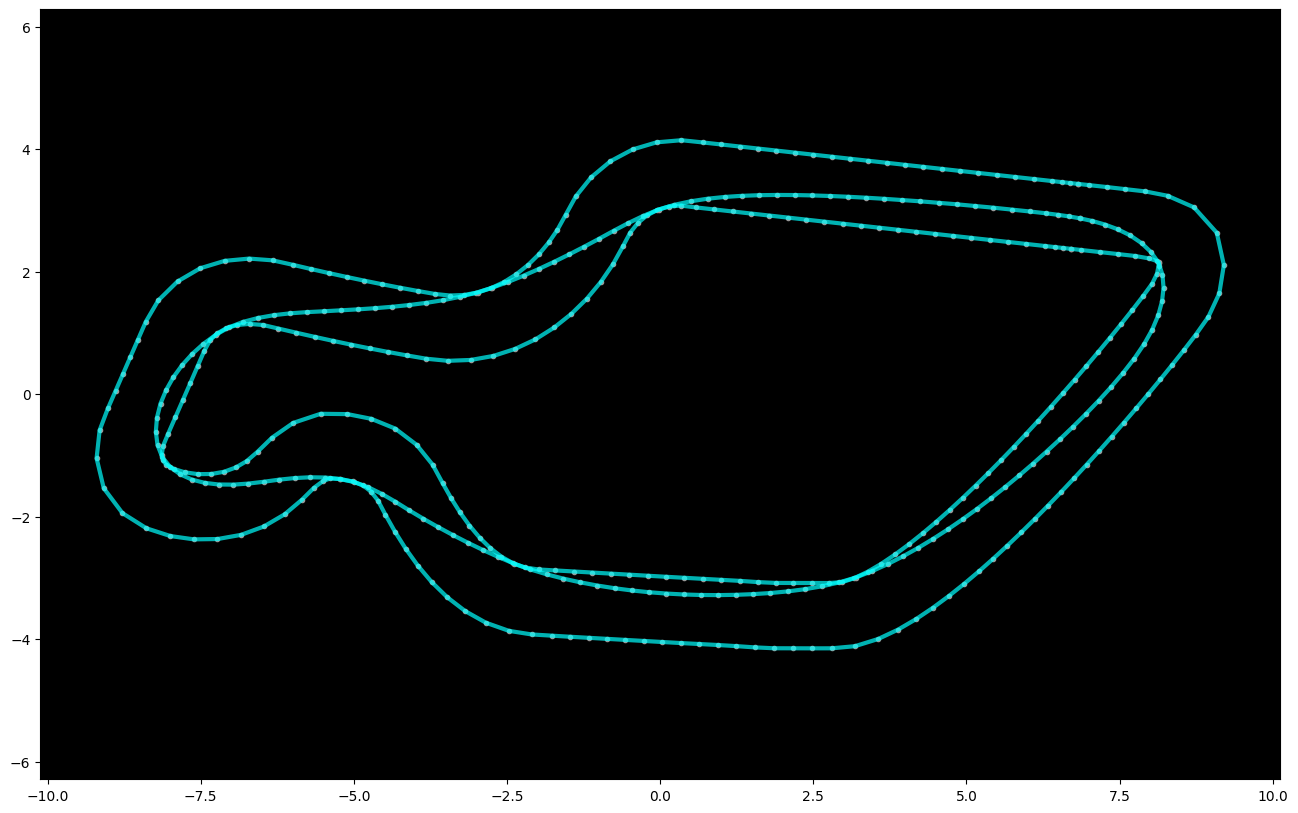

In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

In [ ]:
np.save("optimal_track.npy", loop_race_line)

# Find Action Space by Optimal Track

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Path of the optimal racing line (.npy file)
fpath = "optimal_track.npy"

# Change manually (this is only so that output files are named correctly)
TRACK_NAME = "optimal_track"

racing_track = np.load(fpath)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

# Extract the first two numbers from each sublist
racing_track = [sublist[:2] for sublist in racing_track]

print(len(racing_track))
print(racing_track[:5])

142
[[6.856444693032392, 2.8718592848904567], [6.672733385515366, 2.903838313135743], [6.492144303096758, 2.9299034988801163], [6.295037492487422, 2.9545297495596414], [6.0370399951934814, 2.9837015867233276]]


In [ ]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [ ]:
LOOK_AHEAD_POINTS = 0
MIN_SPEED = 1.3
MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.5662272406143072


Constant multiple for optimal speed: 1.5662272406143072


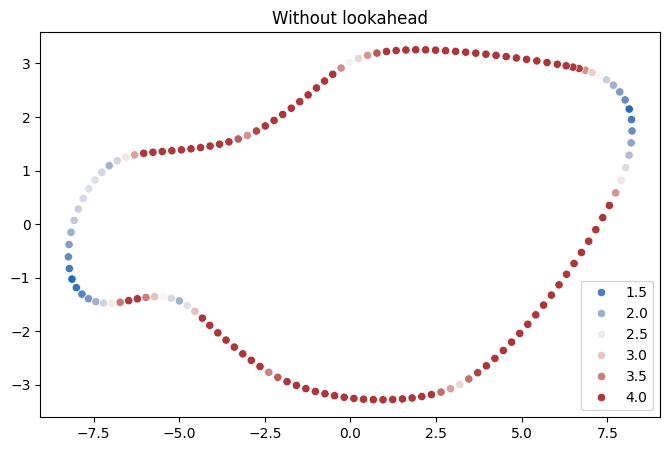

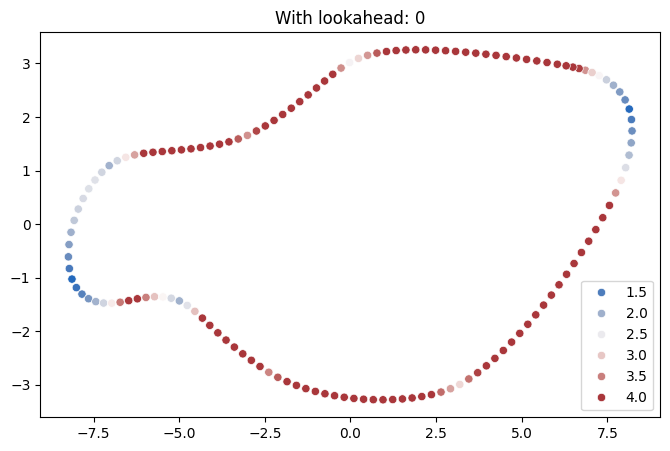

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [ ]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)

time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 11.857163296210228 s


In [ ]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [ ]:
# Write to txt file
with open(f'optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

In [ ]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)

# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})
all_actions.head()

,velocity,steering
0,3.367144,2.045903
1,3.950168,1.486393
2,4.000000,0.945149
3,4.000000,0.482822
4,4.000000,0.204107


In [ ]:
import ast
def read_data(file_path):
    with open(file_path, 'r') as file:
        # Read the entire file content and strip unwanted spaces/newlines
        file_content = file.read().strip()
        # Safely evaluate the string to a Python object (list of lists)
        data = ast.literal_eval(file_content)
    return data
# Path to the file
file_path = "/content/optimals_newest_optimal_track.txt"
# Read the data
data = read_data(file_path)
# Create a DataFrame
df_optimalXY_Speed = pd.DataFrame(data, columns=['x', 'y', 'speed', 'time_from_previous_point'])
df_optimalXY_Speed_steering = pd.concat([df_optimalXY_Speed, all_actions], axis=1)
df_optimalXY_velocity_steering = df_optimalXY_Speed_steering.drop(['speed','time_from_previous_point'], axis=1)
print(len(df_optimalXY_velocity_steering))
df_optimalXY_velocity_steering.head()

142


,x,y,velocity,steering
0,6.85644,2.87186,3.367144,2.045903
1,6.67273,2.90384,3.950168,1.486393
2,6.49214,2.92990,4.000000,0.945149
3,6.29504,2.95453,4.000000,0.482822
4,6.03704,2.98370,4.000000,0.204107


In [ ]:
df_optimalXY_velocity_steering.to_csv('df_optimalXY_velocity_steering.csv', index=False)

In [ ]:
df_optimalXY_velocity_steering.describe()

,x,y,velocity,steering
count,142.000000,142.000000,142.000000,142.000000
mean,0.012811,0.157152,3.328897,1.771754
std,5.264417,2.291798,0.889470,3.195558
min,-8.233440,-3.279030,1.300000,-5.720125
25%,-4.626848,-1.841030,2.582358,0.225224
50%,-0.104535,0.413275,4.000000,0.862220
75%,4.807663,2.388140,4.000000,2.553261
max,8.218160,3.253710,4.000000,13.857073


In [ ]:
# Now we have list with columns (x,y,speed,distance,time)
optimalXY_velocity_steering = []
for i in range(len(racing_track)):
    optimalXY_velocity_steering.append([df_optimalXY_velocity_steering["x"][i],
                                    df_optimalXY_velocity_steering["y"][i],
                                    df_optimalXY_velocity_steering["velocity"][i],
                                    df_optimalXY_velocity_steering["steering"][i]])
# Round to 5 decimals
optimalXY_velocity_steering = np.around(optimalXY_velocity_steering, 5).tolist()
# Write to txt file
with open(f'OptimalXY_velocity_steering.txt', 'w') as f:
    f.write("[")
    for line in optimalXY_velocity_steering:
        f.write("%s" % line)
        if line != optimalXY_velocity_steering[-1]:
            f.write(",\n")
    f.write("]")

# Use K means and Gaussian Noise to find action space

Text(0.5, 1.0, 'With lookahead: 1')

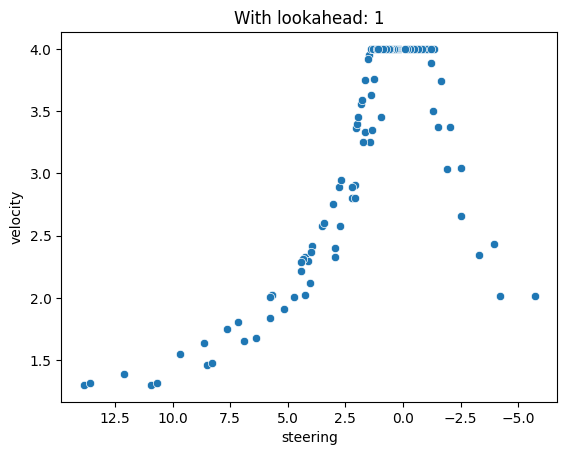

In [ ]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

In [ ]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
print(steering_sd)
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
print(velocity_sd)

9.119352478676534
0.0


In [ ]:
print(all_actions.head())
print(len(all_actions))

   velocity  steering
0  3.367144  2.045903
1  3.950168  1.486393
2  4.000000  0.945149
3  4.000000  0.482822
4  4.000000  0.204107
142


In [ ]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1700

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)

# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]

# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(144071, 2)

In [ ]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X),
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 30-4
model = MiniBatchKMeans(n_clusters=n_clusters, random_state=88).fit(X_minmax)

# Centroids (interpretable)
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_),
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[1.3,1.3],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

# Improve the K-means into K-means++

In [ ]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X),
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 30-4
model = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', random_state=88).fit(X_minmax)

# Centroids (interpretable)
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids_1 = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_),
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[1.3,1.3],"steering":[30,-30]})
X_centroids_1 = pd.concat([X_centroids_1,manual_actions], ignore_index=True)

action_space_e_1 = X_centroids.copy()

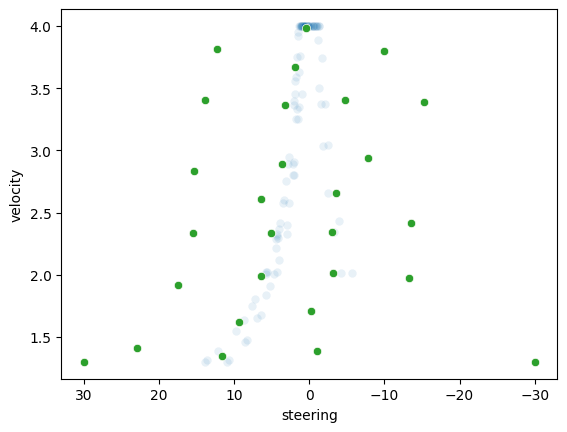

In [ ]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity", alpha = 0.2)
ax = sns.scatterplot(data=action_space_e_1, x="steering", y="velocity")
ax.invert_xaxis()

In [ ]:
# Output JSON format
action_space_for_json = action_space_e_1[["steering","velocity"]].copy()

action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
new_rows = pd.DataFrame([{"steering_angle": 0, "speed": 4}, {"steering_angle": 0, "speed": 3}])

# Concatenate DataFrame with new rows
action_space_for_json = pd.concat([action_space_for_json, new_rows], ignore_index=True)

json_text = action_space_for_json.to_json(orient="records", lines=False)
# Sort the DataFrame by the 'steering_angle' column
action_space_for_json_sorted = action_space_for_json.sort_values(by='steering_angle').reset_index(drop=True)
action_space_for_json_sorted

,steering_angle,speed
0,-30.0000,1.3000
1,-15.2120,3.3880
2,-13.5640,2.4139
3,-13.3315,1.9712
4,-9.9841,3.8001
5,-7.8406,2.9408
6,-4.7657,3.4026
7,-3.6018,2.6542
8,-3.1122,2.0151
9,-3.0568,2.3466


In [ ]:
# Assuming action_space_for_json_sorted is your DataFrame
# Calculate the statistics for the 'speed' column
speed_stats = action_space_for_json_sorted['speed'].describe()

# Calculate the 1st and 3rd quantiles
quantiles = action_space_for_json_sorted['speed'].quantile([0.25, 0.75])

# Construct a dictionary with the calculated statistics
statistics = {
    "min_speed": speed_stats['min'],
    "1st_quantile_speed": quantiles[0.25],
    "mean_speed": speed_stats['mean'],
    "median_speed": speed_stats['50%'],  # This is equivalent to the median
    "3rd_quantile_speed": quantiles[0.75],
    "max_speed": speed_stats['max']
}

# Print the statistics
print(statistics)

{'min_speed': 1.3, '1st_quantile_speed': 1.932425, 'mean_speed': 2.5720666666666667, 'median_speed': 2.51045, '3rd_quantile_speed': 3.3825, 'max_speed': 4.0}


In [ ]:
with open(f'ActionSpace_{TRACK_NAME}.txt', 'w') as f:
    f.write(json_text)
import json

# Sample TXT file content
# Program to read the entire file using read() function
file = open("/content/ActionSpace_optimal_track.txt", "r")
txt_content = file.read()
print(txt_content)

# Convert TXT content to Python list
action_space_list = json.loads(txt_content)

# Create the final JSON structure
json_data = {
    "action_space": action_space_list,
    "sensor": ["FRONT_FACING_CAMERA"],
    "neural_network": "DEEP_CONVOLUTIONAL_NETWORK_SHALLOW",
    "training_algorithm": "clipped_ppo",
    "action_space_type": "discrete",
    "version": "5"
}

# Convert the final JSON structure to a string
json_output = json.dumps(json_data, indent=2)

# Print the result
print(json_output)

# Save to a JSON file
with open('Action_Space_Optimal.json', 'w') as f:
    f.write(json_output)

file.close()


[{"steering_angle":-3.1122,"speed":2.0151},{"steering_angle":-4.7657,"speed":3.4026},{"steering_angle":6.4809,"speed":2.607},{"steering_angle":22.9636,"speed":1.4124},{"steering_angle":0.4996,"speed":3.9872},{"steering_angle":17.5299,"speed":1.9195},{"steering_angle":12.248,"speed":3.8136},{"steering_angle":-7.8406,"speed":2.9408},{"steering_angle":6.4706,"speed":1.9882},{"steering_angle":11.6288,"speed":1.3447},{"steering_angle":-3.0568,"speed":2.3466},{"steering_angle":-13.564,"speed":2.4139},{"steering_angle":-0.9931,"speed":1.3879},{"steering_angle":5.107,"speed":2.3326},{"steering_angle":3.1644,"speed":3.366},{"steering_angle":15.4193,"speed":2.3354},{"steering_angle":15.3941,"speed":2.8354},{"steering_angle":-15.212,"speed":3.388},{"steering_angle":-0.2674,"speed":1.7126},{"steering_angle":3.6474,"speed":2.8933},{"steering_angle":13.8417,"speed":3.4073},{"steering_angle":-9.9841,"speed":3.8001},{"steering_angle":1.8496,"speed":3.666},{"steering_angle":9.3052,"speed":1.6204},{"ste